In [4]:
import numpy as np
import matplotlib

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
	
# Set such that PDF fonts export in a manner that they
# are editable in illustrator/affinity
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# set to define axes linewidths
matplotlib.rcParams['axes.linewidth'] = 0.25

# this defines some prefactors so inline figures look nice
# on a retina macbook. These can be commented out without any
# issue and are solely asthetic.
%matplotlib inline
%config InlineBackend.figure_format='retina'

# UPDATE 2020-12-31 (my preferred font is Avenir...)
font = {'family' : 'avenir',
    	'weight' : 'normal'}

matplotlib.rc('font', **font)
from sparrow import Protein
from sparrow.predictors import batch_predict


# Set rcParams for tick marks
plt.rcParams['xtick.major.size'] = 2  # Length of major ticks (in points)
plt.rcParams['xtick.minor.size'] = 1  # Length of minor ticks (in points)
plt.rcParams['xtick.major.width'] = 0.25  # Width of major ticks (in points)
plt.rcParams['xtick.minor.width'] = 0.25  # Width of minor ticks (in points)

plt.rcParams['ytick.major.size'] = 2  # Length of major ticks (in points)
plt.rcParams['ytick.minor.size'] = 1  # Length of minor ticks (in points)
plt.rcParams['ytick.major.width'] = 0.25  # Width of major ticks (in points)
plt.rcParams['ytick.minor.width'] = 0.25  # Width of minor ticks (in points)

plt.rcParams['xtick.labelsize'] = 5  # Font size for x-axis tick labels
plt.rcParams['ytick.labelsize'] = 5  # Font size for y-axis tick labels

import protfasta

from finches import CALVADOS_frontend, Mpipi_frontend

mf = Mpipi_frontend()
cf = CALVADOS_frontend()
from sparrow import Protein

from shephard import interfaces, apis
from housetools import nucleic_acid_tools 
from housetools.sequence_tools.sequence_conservation import ConservationCalculator



import random

from scipy.stats import ttest_ind, mannwhitneyu, ks_2samp
from mutagenesis import compare

CC=  ConservationCalculator()

/Users/alex/.uv/neuron_uv/.venv/lib/python3.12/site-packages/finches/forcefields/calvados.py:236: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.038286503882254706' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  r.loc['H','q'] = 1. / ( 1 + 10**(self.pH-6) )


In [5]:
def subsample_and_calculate_conservation(seqs, sample_size, reps = 10):
    """
    Subsample sequences from a given dictionary of sequences.

    Parameters:
    -------------------
    seqs : dict
        A dictionary where keys are sequence identifiers and values are sequences.

    sample_size : int
        The number of sequences to sample in each iteration.

    reps : int
        The number of repetitions for sampling.

    Returns:
    -------------------
    vals : list
        A list containing the overall conservation scores for each repetition.

    """
    vals = []
    
    # Extract keys or items (choose based on what you need)
    keys = list(seqs.keys())

    for i in range(reps):
        
        random_k = random.sample(keys, sample_size)

        subseqs = {key: seqs[key] for key in random_k}

        # add wildtype sequence
        subseqs['WT'] = idr2

        CO_silico = CC.calculate_conservation(subseqs, target='WT') 

        vals.append(CO_silico.overall_conservation_scores)
    return vals

    
    

In [ ]:

# read in randomly selected sequences
all_seqs = protfasta.read_fasta('libraries/chemlib_v2_350.fasta')
ncs_viable = protfasta.read_fasta('error_prone_pcr_sequences/ncs_viable.fasta')
ncs_inviable = protfasta.read_fasta('error_prone_pcr_sequences/ncs_inviable.fasta')

idr2 = 'NNNNNNDGELSGTNLRSNSIDYAKHQEISSAGTSSNTTKNVNNNKNDSNDDNNGNNNNDASNLMESVLDKTSSHRYQPKKMPSVNKWSKPDQITHSDVSMVGLDESNDGGNENVHPTLAEVDAQEARETAQLAIDKINSYKRSIDDKNGDGHNNSSRNVVDENLINDMDSEDAHKSKRQHLSDITLEERNEDDKLPHEVAEQLRLLSSHLKEVE'

all_seqs['WT'] = idr2

ncs_viable['WT'] = idr2
ncs_all = ncs_inviable
for k in ncs_viable:
    ncs_all[k] = ncs_viable[k]
    
CO_silico = CC.calculate_conservation(all_seqs, target='WT')
CO_NCS = CC.calculate_conservation(ncs_viable, target='WT')

In [7]:
all_comps = []
for k in ncs_all:
    if k=='WT':
        pass
    all_comps.append(compare(idr2, ncs_all[k], verbose=False))
average_ncs_mutations_all = np.mean(all_comps)
print(f"Average mutations per sequence {average_ncs_mutations_all}")

Average mutations per sequence 39.775510204081634


In [8]:
all_comps = []
for k in ncs_viable:
    if k=='WT':
        pass
    all_comps.append(compare(idr2, ncs_viable[k], verbose=False))
average_ncs_mutations = np.mean(all_comps)
print(f"Average mutations per sequence in viable {average_ncs_mutations}")

Average mutations per sequence in viable 26.0


In [10]:
all_comps = []
for k in all_seqs:
    if k=='WT':
        pass
    all_comps.append(compare(idr2, all_seqs[k], verbose=False))
average_in_silico_mutations = np.mean(all_comps)
print(f"Average mutations per sequence in in-silico {average_in_silico_mutations}")

Average mutations per sequence in in-silico 27.60683760683761


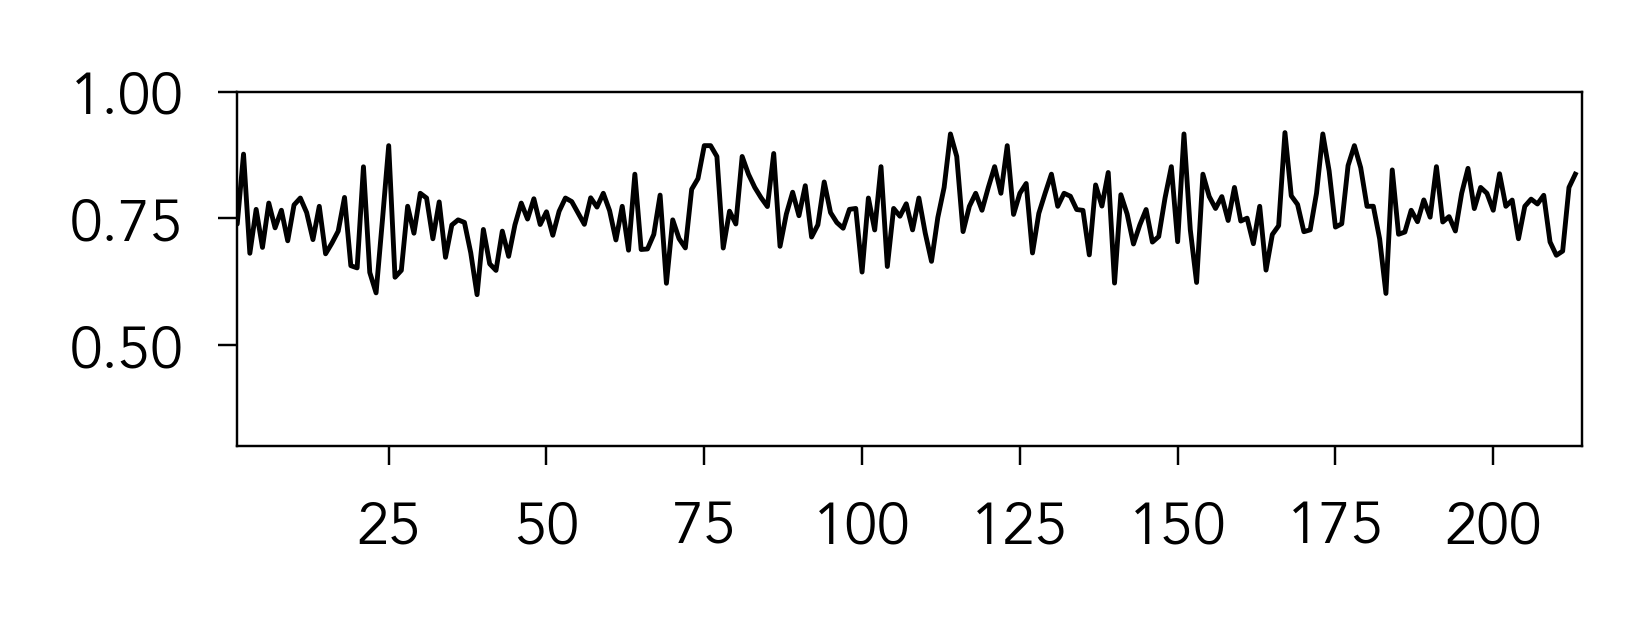

In [12]:
total_vals = []
for i in range(30):
    total_vals.append(np.mean(subsample_and_calculate_conservation(all_seqs, len(ncs_viable),1),0))

total_vals = np.array(total_vals)
lower_bound = np.min(total_vals,0)
upper_bound = np.max(total_vals,0)
x = np.arange(1,len(idr2)+1)

WITH_DISTRIBUTION = False

figure(None, (2.413,1.), dpi=350)

if WITH_DISTRIBUTION:
    plt.fill_between(x, lower_bound, upper_bound,  facecolor='blue', alpha=0.2, interpolate=True)

plt.plot(CO_NCS.overall_conservation_scores, color='k',lw=0.5)

plt.xlim([x[0],x[-1]])
plt.ylim([0.3,1])

plt.yticks(fontsize=6)
plt.xticks(fontsize=6)

plt.tight_layout()

if WITH_DISTRIBUTION:
    plt.savefig('figures/linear_conservation_no_distribution.pdf')
else:
    plt.savefig('figures/linear_conservation_with_distribution.pdf')

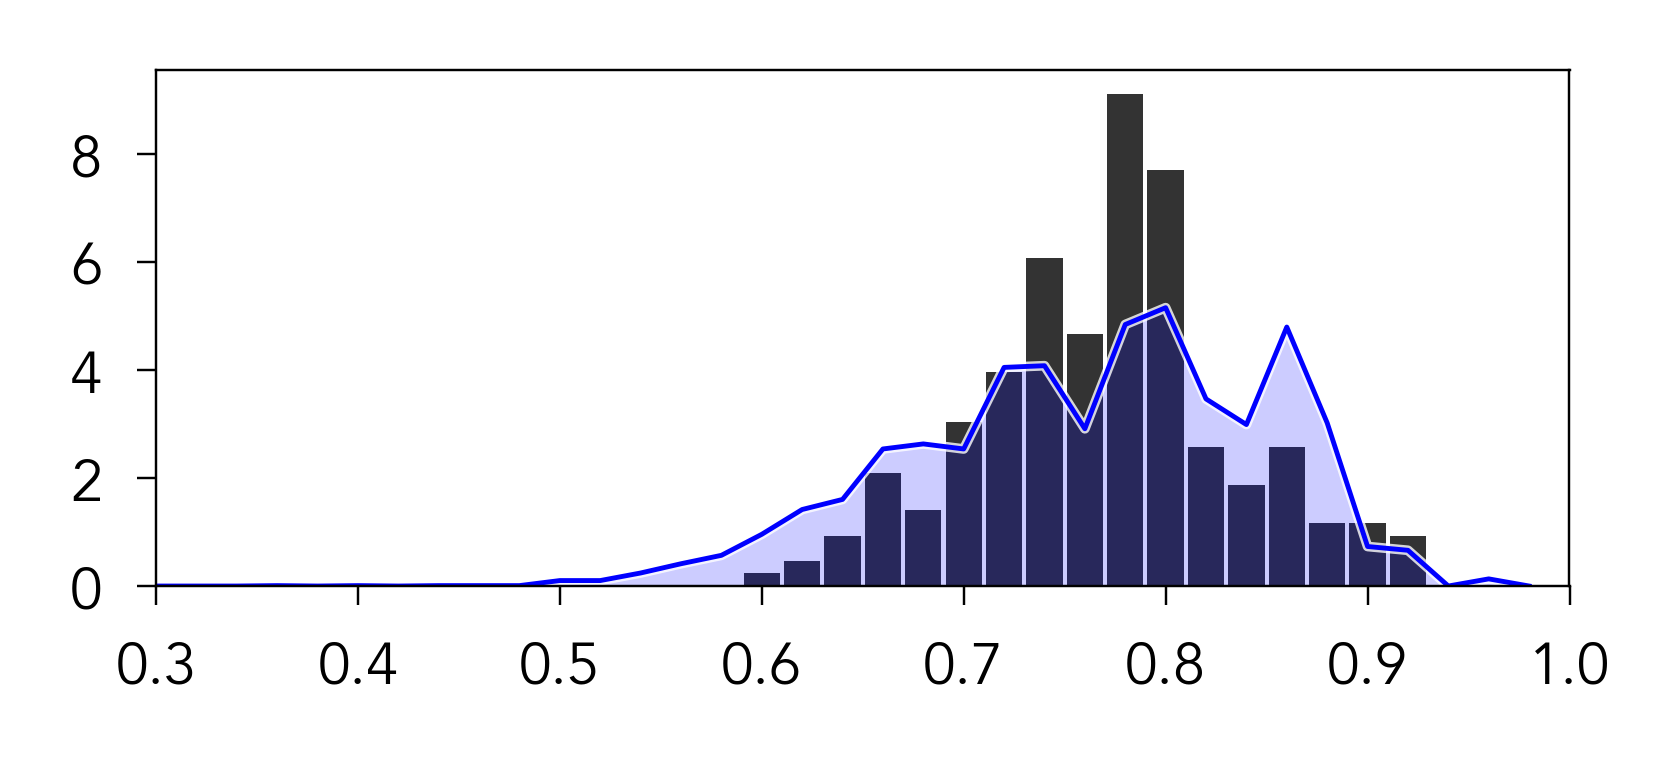

In [14]:

figure(None, (2.5,1.2), dpi=350)
bw = 0.02
bins = np.arange(0,1,bw)

bw = 0.02
bins = np.arange(0,1,bw)
X = np.histogram(CO_NCS.overall_conservation_scores,bins=bins, density=True)
#plt.bar(X[1][1:], X[0]/np.max(X[0]),width=bw*0.9, color='k', alpha=0.8)
plt.bar(X[1][1:], X[0],width=bw*0.9, color='k', alpha=0.8)

X = np.histogram(total_vals.flatten(),bins=bins,density=True)

plt.plot(X[1][1:], X[0], color='w',alpha=0.8, lw=1)
plt.plot(X[1][1:], X[0], color='blue',alpha=1, lw=0.5)
plt.fill_between(X[1][1:], X[0], where=(X[0]>=0), facecolor='blue', alpha=0.2, interpolate=False, lw=0)

plt.yticks(fontsize=6)
plt.xticks(fontsize=6)
plt.xlim([0.3,1])
plt.tight_layout()

plt.savefig('figures/conservation_with_distribution.pdf')